# Data Exploration and Visualization

This notebook is designed to explore and visualize the dataset. The main goals are to:

- Perform visual analysis of the data using Seaborn plots.
- Analyze correlation patterns to identify feature relevance.
- Interpret the distribution of features across different categories like `LOS` and `NLOS`.
The visualizations will help in understanding the relationship between variables and inform any further preprocessing steps.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score


In [7]:
data = pd.read_csv('../data/processed/aggregated_dataset.csv')
print("Cleaned dataset shape:", data.shape)
data.head()

Cleaned dataset shape: (40677, 1030)


,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,...,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015,CIR_MEAN,CIR_VAR,CIR_SKEW,CIR_ENERGY_FIRST_100
0,0.0,3.90,745.0,18712.0,10250.0,11576.0,64.0,11855.0,967.0,611.0,...,198.0,87.0,296.0,505.0,307.0,0.0,395.225394,1.503746e+06,10.561181,22550.0
1,0.0,0.66,749.0,11239.0,6313.0,4712.0,64.0,18968.0,1133.0,447.0,...,187.0,213.0,202.0,89.0,103.0,0.0,444.060039,2.665030e+06,8.523565,20796.0
2,1.0,7.86,746.0,4355.0,5240.0,3478.0,60.0,14699.0,894.0,723.0,...,124.0,329.0,207.0,96.0,218.0,0.0,503.485236,1.859169e+06,7.101177,21061.0
3,1.0,3.48,750.0,8502.0,8416.0,5890.0,76.0,8748.0,1127.0,1024.0,...,434.0,397.0,290.0,155.0,342.0,256.0,413.054134,1.097226e+06,9.486008,26896.0
4,0.0,1.19,746.0,17845.0,18095.0,12058.0,68.0,11380.0,1744.0,276.0,...,87.0,178.0,314.0,247.0,292.0,256.0,363.357283,1.438949e+06,11.789746,21277.0


In [8]:
print("Data types for each column:")
print(data.dtypes)

# Print number of elements
print(f"Total number of elements: {data.size}")

# Print range of each numeric column
print("\nRange for each numeric column:")
for column in data.select_dtypes(include=[np.number]).columns:
    print(f"{column} range: {data[column].min()} to {data[column].max()}")

Data types for each column:
NLOS                    float64
RANGE                   float64
FP_IDX                  float64
FP_AMP1                 float64
FP_AMP2                 float64
                         ...   
CIR1015                 float64
CIR_MEAN                float64
CIR_VAR                 float64
CIR_SKEW                float64
CIR_ENERGY_FIRST_100    float64
Length: 1030, dtype: object
Total number of elements: 41897310

Range for each numeric column:
NLOS range: 0.0 to 1.0
RANGE range: 0.0 to 28.02
FP_IDX range: 707.0 to 848.0
FP_AMP1 range: 7.0 to 20572.0
FP_AMP2 range: 63.0 to 20624.0
FP_AMP3 range: 187.0 to 20577.0
STDEV_NOISE range: 28.0 to 220.0
CIR_PWR range: 0.0 to 31709.0
MAX_NOISE range: 310.0 to 5169.0
RXPACC range: 128.0 to 1056.0
CIR0 range: 2.0 to 844.0
CIR1 range: 3.0 to 912.0
CIR2 range: 1.0 to 916.0
CIR3 range: 0.0 to 997.0
CIR4 range: 1.0 to 1256.0
CIR5 range: 1.0 to 1012.0
CIR6 range: 1.0 to 1057.0
CIR7 range: 0.0 to 1007.0
CIR8 range: 0.0 to 895.0

In [9]:
print(data['NLOS'].value_counts(normalize=True))

0.0    0.507043
1.0    0.492957
Name: NLOS, dtype: float64


## Box Plot Visualization

Box plots are used to visualize the distribution of data and detect outliers. In this example, we plot the distribution of the `CIR_SKEW` feature for `LOS` and `NLOS` labels.

- **CIR_SKEW**: Represents the skewness of the channel impulse response, which can provide insights into signal characteristics.
- **NLOS**: Non-Line of Sight, indicating obstructions in the transmission path.

The box plot helps to identify differences in the distribution of skewness values for LOS and NLOS scenarios.

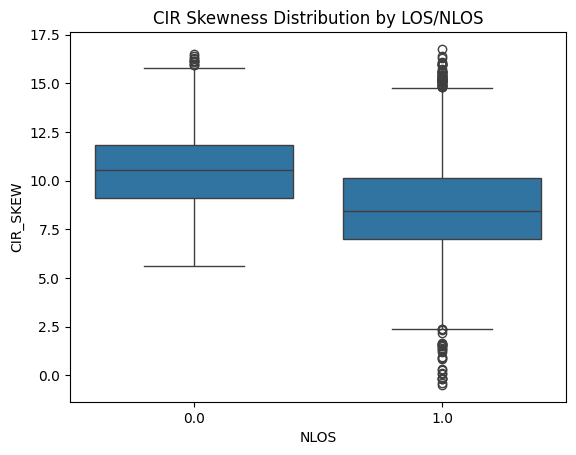

In [10]:
import seaborn as sns

# Example: CIR_SKEW vs. NLOS
sns.boxplot(x="NLOS", y="CIR_SKEW", data=data)
plt.title("CIR Skewness Distribution by LOS/NLOS")
plt.show()

<Axes: xlabel='NLOS', ylabel='CIR_PEAK_BIN'>

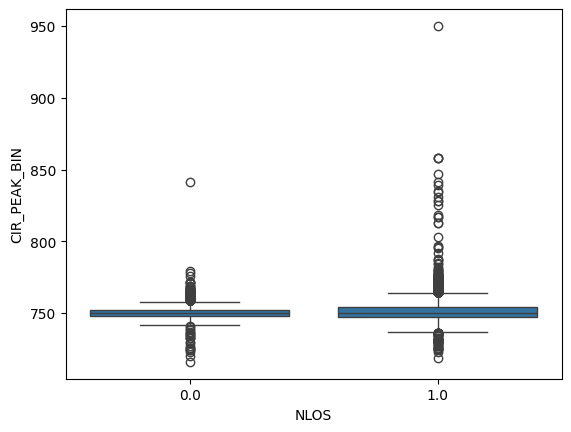

In [11]:
data['CIR_PEAK_BIN'] = data.loc[:, 'CIR0':'CIR1015'].idxmax(axis=1).str.extract('(\d+)').astype(int)
sns.boxplot(x='NLOS', y='CIR_PEAK_BIN', data=data)

In [12]:
# Calculate RISE_TIME
data['RISE_TIME'] = data['CIR_PEAK_BIN'] - data['FP_IDX']

# Filter invalid values
data = data[data['RISE_TIME'] >= 0]

# Clip outliers
rise_time_threshold = data['RISE_TIME'].quantile(0.99)
data['RISE_TIME_CLIPPED'] = data['RISE_TIME'].clip(upper=rise_time_threshold)

# Verify
data.to_csv('../data/processed/aggregated_dataset.csv', index=False)

In [13]:
print(data['RISE_TIME'].describe())

count    40674.000000
mean         5.194326
std          5.272344
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        191.000000
Name: RISE_TIME, dtype: float64


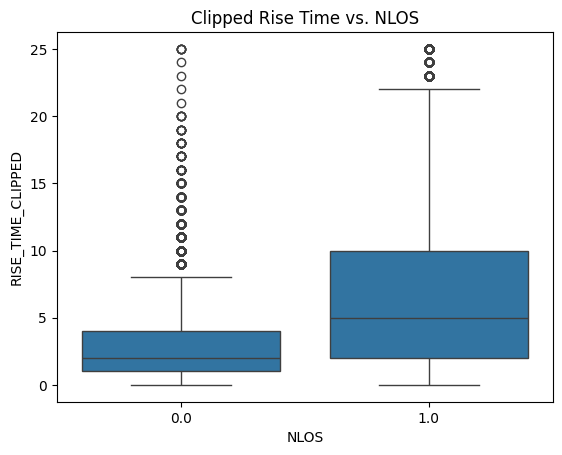

In [14]:
sns.boxplot(x="NLOS", y="RISE_TIME_CLIPPED", data=data)
plt.title("Clipped Rise Time vs. NLOS")
plt.show()

In [15]:
from scipy.stats import ttest_ind
los_skew = data[data['NLOS'] == 0]['CIR_SKEW']
nlos_skew = data[data['NLOS'] == 1]['CIR_SKEW']
t_stat, p_value = ttest_ind(los_skew, nlos_skew)
print(f"p-value: {p_value:.4f}")  # Expect p < 0.05

p-value: 0.0000
